<a href="https://colab.research.google.com/github/leahnagy/yoga_pose_classifier/blob/main/code/DL_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Get labels for classes
labels = list()
train_path=os.path.join("DATASET", "TRAIN")
test_path = os.path.join("DATASET", "TEST")
for i in os.listdir(train_path):
  labels.append(i)
print(labels)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']


In [5]:
# Counting the training samples
Total_sample=0
for i in os.listdir(train_path):
    print(f'Length of :{i}= {len(os.listdir(os.path.join(train_path,i)))}')
    Total_sample+=len(os.listdir(os.path.join(train_path,i)))
print(f'Total Samples:{Total_sample}')

Length of :downdog= 223
Length of :goddess= 180
Length of :plank= 266
Length of :tree= 159
Length of :warrior2= 252
Total Samples:1080


In [6]:
# Counting the testing samples
Total_sample=0
for i in os.listdir(test_path):
    print(f'Length of :{i}= {len(os.listdir(os.path.join(test_path,i)))}')
    Total_sample+=len(os.listdir(os.path.join(test_path,i)))
print(f'Total Samples:{Total_sample}')

Length of :downdog= 97
Length of :goddess= 80
Length of :plank= 114
Length of :tree= 69
Length of :warrior2= 109
Total Samples:469


In [7]:
# test out augmentation
image_generator = ImageDataGenerator(featurewise_center=True,
                                     featurewise_std_normalization=True,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                     validation_split=0.2)    

train_dataset = image_generator.flow_from_directory(batch_size=10,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

validation_dataset = image_generator.flow_from_directory(batch_size=10,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

Found 866 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


In [8]:
print('Number of samples: ',train_dataset.samples)

Number of samples:  866


In [9]:
# Preprocess images and split into training and validation sets
# Using VGG16 preprocessing
image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications
                                   .vgg16.preprocess_input, validation_split=0.2)    

train_dataset = image_generator.flow_from_directory(batch_size=10,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

validation_dataset = image_generator.flow_from_directory(batch_size=10,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

Found 866 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


In [10]:
# Preprocess images of test set
test_dataset = ImageDataGenerator(preprocessing_function=tf.keras.applications
                                   .vgg16.preprocess_input).flow_from_directory\
                                   (directory=test_path, target_size=(224,224), 
                         classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'], 
                         batch_size=10, shuffle=False)

Found 469 images belonging to 5 classes.


In [11]:
imgs, labels = next(train_dataset)

In [12]:
def plotImages(images_arr):
  """
  Function to display images.
  Color will be distorted from VGG16 preprocessing.
  """
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    image = np.clip(img, 0, 1)
    ax.imshow(image)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

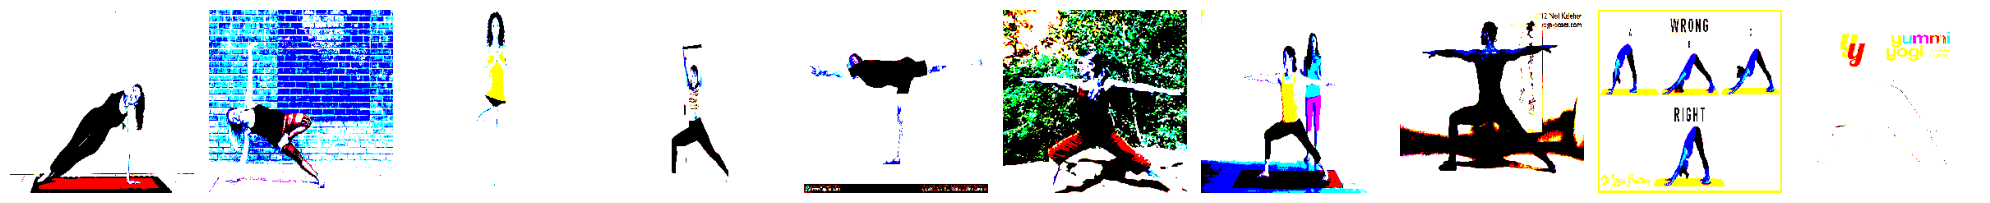

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [13]:
plotImages(imgs)
print(labels)

## One hot encoding labels:
[warrior2, downdog, tree, plank, goddess]


## Build and train a CNN

In [14]:
# Build CNN with no early stopping or drop out layers
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=5, activation='softmax'),                    
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(x=train_dataset, validation_data=validation_dataset, epochs=10, verbose=2)

Epoch 1/10


c:\ProgramData\Anaconda3\envs\rdi\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87/87 - 18s - loss: 81.3665 - accuracy: 0.3083 - val_loss: 10.1419 - val_accuracy: 0.4299 - 18s/epoch - 212ms/step
Epoch 2/10
87/87 - 11s - loss: 6.3900 - accuracy: 0.6409 - val_loss: 9.0144 - val_accuracy: 0.4720 - 11s/epoch - 130ms/step
Epoch 3/10
87/87 - 12s - loss: 1.6090 - accuracy: 0.8441 - val_loss: 7.1633 - val_accuracy: 0.6121 - 12s/epoch - 132ms/step
Epoch 4/10
87/87 - 11s - loss: 0.2479 - accuracy: 0.9538 - val_loss: 5.1056 - val_accuracy: 0.6355 - 11s/epoch - 132ms/step
Epoch 5/10
87/87 - 12s - loss: 0.1450 - accuracy: 0.9665 - val_loss: 5.5170 - val_accuracy: 0.6636 - 12s/epoch - 136ms/step
Epoch 6/10
87/87 - 13s - loss: 0.1654 - accuracy: 0.9688 - val_loss: 4.4098 - val_accuracy: 0.6916 - 13s/epoch - 144ms/step
Epoch 7/10
87/87 - 12s - loss: 0.0377 - accuracy: 0.9908 - val_loss: 4.2371 - val_accuracy: 0.7056 - 12s/epoch - 142ms/step
Epoch 8/10
87/87 - 12s - loss: 0.0530 - accuracy: 0.9873 - val_loss: 4.5800 - val_accuracy: 0.6636 - 12s/epoch - 136ms/step
Epoch 9/10
87/87 

In [18]:
predictions = model.predict(x=validation_dataset, steps=len(validation_dataset), verbose=0)

### Confusion Matrix CNN - Baseline

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
labels = ['warrior2', 'downdog', 'tree', 'plank', 'goddess']
cm = confusion_matrix(y_true=validation_dataset.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[25  5  7  8  5]
 [20  6  5  7  6]
 [13  2  4  5  7]
 [20  5  8 13  7]
 [16  6  3  6  5]]


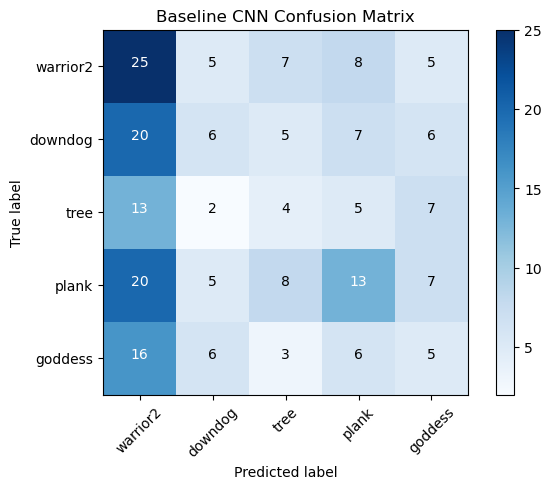

In [21]:
plot_confusion_matrix(cm=cm, classes=labels, title='Baseline CNN Confusion Matrix')

## Discussion
**Results**
<ul>
<li> Test Set Accuracy: 0.9908 </li>
<li> Val Set Accuracy: 0.6355 </li>
</ul>
<br>

**Why is the test set performing better than the validation set?** <br>
The model is overfitting.




## Refine Model
To combat overfitting, add the following:
- Early stopping
- Dropout layers

In [22]:
# Build CNN with early drop out layers
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.8),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.5),
    Flatten(),
    Dense(units=5, activation='softmax'),                    
])

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [24]:
model.fit(x=train_dataset, validation_data=validation_dataset, epochs=10, verbose=2)

Epoch 1/10


c:\ProgramData\Anaconda3\envs\rdi\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87/87 - 12s - loss: 333.7822 - accuracy: 0.2229 - val_loss: 33.1841 - val_accuracy: 0.2617 - 12s/epoch - 140ms/step
Epoch 2/10
87/87 - 11s - loss: 167.5374 - accuracy: 0.2702 - val_loss: 9.7063 - val_accuracy: 0.3131 - 11s/epoch - 132ms/step
Epoch 3/10
87/87 - 12s - loss: 91.1797 - accuracy: 0.3614 - val_loss: 6.2935 - val_accuracy: 0.4439 - 12s/epoch - 133ms/step
Epoch 4/10
87/87 - 12s - loss: 74.4196 - accuracy: 0.3614 - val_loss: 4.0026 - val_accuracy: 0.4953 - 12s/epoch - 133ms/step
Epoch 5/10
87/87 - 11s - loss: 42.9800 - accuracy: 0.4434 - val_loss: 3.0048 - val_accuracy: 0.4626 - 11s/epoch - 132ms/step
Epoch 6/10
87/87 - 11s - loss: 30.1731 - accuracy: 0.4838 - val_loss: 2.8408 - val_accuracy: 0.4673 - 11s/epoch - 131ms/step
Epoch 7/10
87/87 - 11s - loss: 24.5069 - accuracy: 0.5185 - val_loss: 2.3983 - val_accuracy: 0.4860 - 11s/epoch - 132ms/step
Epoch 8/10
87/87 - 12s - loss: 18.5406 - accuracy: 0.5508 - val_loss: 2.4187 - val_accuracy: 0.5047 - 12s/epoch - 133ms/step
Epoch 9/

### Add Early Stopping

In [25]:
# model with early stopping and ReduceLROnPlateau
model.fit(
    x=train_dataset, validation_data=validation_dataset, epochs=10, verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=9, verbose=2, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=2)
    ])

Epoch 1/10
87/87 - 12s - loss: 11.7859 - accuracy: 0.6443 - val_loss: 1.9825 - val_accuracy: 0.5234 - lr: 1.0000e-04 - 12s/epoch - 136ms/step
Epoch 2/10
87/87 - 11s - loss: 9.2360 - accuracy: 0.6836 - val_loss: 1.8605 - val_accuracy: 0.5187 - lr: 1.0000e-04 - 11s/epoch - 132ms/step
Epoch 3/10
87/87 - 12s - loss: 8.1893 - accuracy: 0.7009 - val_loss: 1.9578 - val_accuracy: 0.5093 - lr: 1.0000e-04 - 12s/epoch - 133ms/step
Epoch 4/10
87/87 - 12s - loss: 7.8243 - accuracy: 0.7298 - val_loss: 1.8065 - val_accuracy: 0.5327 - lr: 1.0000e-04 - 12s/epoch - 132ms/step
Epoch 5/10
87/87 - 12s - loss: 6.6640 - accuracy: 0.7436 - val_loss: 1.7420 - val_accuracy: 0.5748 - lr: 1.0000e-04 - 12s/epoch - 134ms/step
Epoch 6/10
87/87 - 12s - loss: 5.8385 - accuracy: 0.7587 - val_loss: 1.6527 - val_accuracy: 0.5561 - lr: 1.0000e-04 - 12s/epoch - 137ms/step
Epoch 7/10
87/87 - 11s - loss: 8.0460 - accuracy: 0.7067 - val_loss: 1.6370 - val_accuracy: 0.5561 - lr: 1.0000e-04 - 11s/epoch - 131ms/step
Epoch 8/10
8

### Add Data Augmentation
To continue to address overfitting, this model will include data augmentation, early stopping, and drop out layers. 

In [26]:
# data augmentation datasets
image_generator = ImageDataGenerator(featurewise_center=True,
                                     featurewise_std_normalization=True,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                     validation_split=0.2)    

train_dataset = image_generator.flow_from_directory(batch_size=10,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

validation_dataset = image_generator.flow_from_directory(batch_size=10,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

Found 866 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


In [27]:
# fit the above datasets
model.fit(
    x=train_dataset, validation_data=validation_dataset, epochs=10, verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=9, verbose=2, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=2)
    ])

Epoch 1/10


c:\ProgramData\Anaconda3\envs\rdi\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\rdi\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


87/87 - 19s - loss: 29.6890 - accuracy: 0.2483 - val_loss: 2.0220 - val_accuracy: 0.2383 - lr: 1.0000e-04 - 19s/epoch - 216ms/step
Epoch 2/10
87/87 - 18s - loss: 20.5493 - accuracy: 0.2691 - val_loss: 1.9941 - val_accuracy: 0.2009 - lr: 1.0000e-04 - 18s/epoch - 207ms/step
Epoch 3/10
87/87 - 19s - loss: 18.4737 - accuracy: 0.2633 - val_loss: 1.7597 - val_accuracy: 0.2243 - lr: 1.0000e-04 - 19s/epoch - 218ms/step
Epoch 4/10
87/87 - 19s - loss: 16.4543 - accuracy: 0.2725 - val_loss: 1.7119 - val_accuracy: 0.2150 - lr: 1.0000e-04 - 19s/epoch - 222ms/step
Epoch 5/10
87/87 - 19s - loss: 13.9982 - accuracy: 0.2540 - val_loss: 1.6178 - val_accuracy: 0.2290 - lr: 1.0000e-04 - 19s/epoch - 217ms/step
Epoch 6/10
87/87 - 18s - loss: 12.2663 - accuracy: 0.2679 - val_loss: 1.6217 - val_accuracy: 0.2009 - lr: 1.0000e-04 - 18s/epoch - 212ms/step
Epoch 7/10
87/87 - 19s - loss: 12.2932 - accuracy: 0.2691 - val_loss: 1.6313 - val_accuracy: 0.2103 - lr: 1.0000e-04 - 19s/epoch - 213ms/step
Epoch 8/10

Epoch

## Discussion
The model is still overfitting after adding Dropout layers and early stopping. Augmenting the images in the training dataset to increase the sample size could be useful. Another option is to use transfer learning.

## Transfer Learning with VGG16 

In [28]:
# Import vgg16
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 41s 0us/step


In [29]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
# Create a sequential model and add the same layers as VGG16
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [31]:
# Make layers non-trainable to freeze weights/params
for layer in model.layers:
  layer.trainable=False

In [32]:
# add trainable output layer with 5 nodes for the 5 classes
model.add(Dense(units=5, activation='softmax'))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model.fit(x=train_dataset,
          steps_per_epoch=len(train_dataset),
          validation_data=validation_dataset,
          validation_steps=len(validation_dataset),
          epochs=5,
          verbose=2)

Epoch 1/5
87/87 - 24s - loss: 1.8342 - accuracy: 0.2898 - val_loss: 1.4977 - val_accuracy: 0.4065 - 24s/epoch - 278ms/step
Epoch 2/5
87/87 - 19s - loss: 1.2770 - accuracy: 0.5092 - val_loss: 1.2445 - val_accuracy: 0.5047 - 19s/epoch - 217ms/step
Epoch 3/5
87/87 - 20s - loss: 1.0732 - accuracy: 0.5970 - val_loss: 1.0351 - val_accuracy: 0.6308 - 20s/epoch - 228ms/step
Epoch 4/5
87/87 - 18s - loss: 0.9184 - accuracy: 0.6697 - val_loss: 0.9450 - val_accuracy: 0.6776 - 18s/epoch - 204ms/step
Epoch 5/5
87/87 - 18s - loss: 0.8344 - accuracy: 0.7079 - val_loss: 0.8488 - val_accuracy: 0.7243 - 18s/epoch - 204ms/step


## Results using VGG16

**VGG16**
<ul>
<li> Test Set Accuracy: 0.8462 </li>
<li> Val Set Accuracy: 0.7991 </li>
</ul>
<br>

**Baseline**
<ul>
<li> Test Set Accuracy: 0.9908 </li>
<li> Val Set Accuracy: 0.6355 </li>
</ul>
<br>

## Make Predictions

In [36]:
predictions = model.predict(x=test_dataset, steps=len(test_dataset), verbose=0)

## Confusion Matrix

Confusion matrix, without normalization
[[93  0  9  0  7]
 [ 3 79  2  9  4]
 [ 9  0 58  0  2]
 [ 7  5  9 93  0]
 [16  2  9  3 50]]


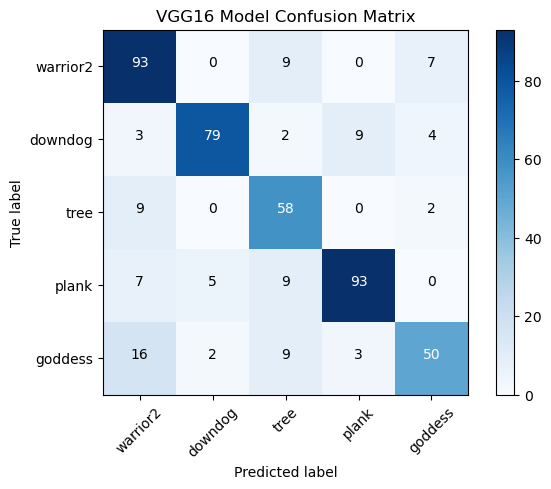

In [37]:
cm = confusion_matrix(y_true=test_dataset.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['warrior2', 'downdog', 'tree', 'plank', 'goddess']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='VGG16 Model Confusion Matrix')